# Exercises, inter- and intra-annual variability of precipitation
> exercises

- toc: true 
- badges: true
- comments: false
- categories: [jupyter]

Import relevant packages

In [1]:
#collapse-hide

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calendar import month_abbr
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import urllib.request
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## intra-annual variability

Go to NOAA's National Centers for Environmental Information (NCEI)  
[Climate Data Online: Dataset Discovery](https://www.ncdc.noaa.gov/cdo-web/datasets)

Find station codes in this [map](https://www.ncei.noaa.gov/maps/monthly/). On the left, click on the little wrench (🔧) next to "Global Summary of the Month", then click on "identify" on the panel that just opened, and click on a station (purple circle). You will see the station's name, it's ID, and the period of record. For example, for Ben-Gurion's Airport in Israel:  
BEN GURION, IS  
STATION ID: ISM00040180  
Period of Record: 1951-01-01 to 2020-03-01

You can download **daily** or **monthly** data for each station. Use the function below to download this data to your computer.

In [2]:
#collapse-hide

def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data - uncomment the next 2 lines to make this work
    # urllib.request.urlretrieve(url_daily + station_code + '.csv',
    #                            station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

Now, choose any station with a period of record longer than 30 years, and download its data:  
```python
download_data('BEN_GURION', 'ISM00040180')
```

Load the data into a datafram, and before you continue with the analysis, plot the rainfall data, to see how it looks like.  

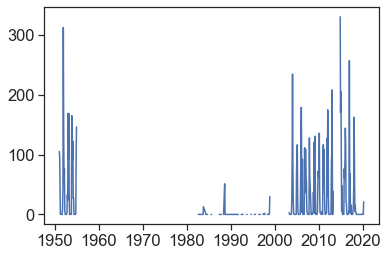

In [3]:
#collapse-hide

download_data('BEN_GURION', 'ISM00040180')
df = pd.read_csv('BEN_GURION_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP'])

It doesn't look great for Ben-Gurion airport, lots of missing data! You might need to choose another station...  Download data for Beer Sheva, ID `IS000051690`.

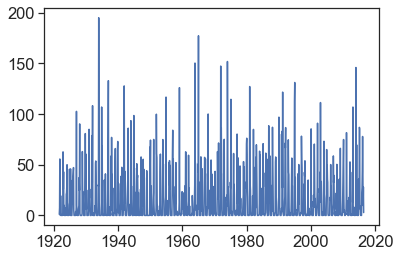

In [4]:
#collapse-hide

download_data('BEER_SHEVA', 'IS000051690')
df = pd.read_csv('BEER_SHEVA_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP'])

That's much better!
We need to aggregate all data from each month, so we can calculate monthly averages. How to do that?

In [5]:
#collapse-hide

# choose only the precipitation column
df_month = df['PRCP']
# calculate monthly mean
monthly_mean = np.array([])  # empty array
month_numbers = np.arange(1,13)
month_names = [month_abbr[i] for i in month_numbers]

for m in month_numbers:      # cycle over months (1, 2, 3, etc)
    this_month_all_indices = (df_month.index.month == m)       # indices in df_month belonging to month m
    this_month_mean = df_month[this_month_all_indices].mean()  # this is the monthly mean
    monthly_mean = np.append(monthly_mean, this_month_mean)    # append

Now it is time to create a new dataframe with the monthly means.

In [6]:
#collapse-hide

df_beersheva = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                             'month names':month_names,
                             'month number':month_numbers
                            })
df_beersheva

,monthly rainfall (mm),month names,month number
0,48.743158,Jan,1
1,37.347368,Feb,2
2,26.551579,Mar,3
3,9.038947,Apr,4
4,2.735789,May,5
5,0.013830,Jun,6
6,0.000000,Jul,7
7,0.002128,Aug,8
8,0.271277,Sep,9
9,6.669474,Oct,10


Plot the data and see if it makes sense. Try to get a figure like this one.

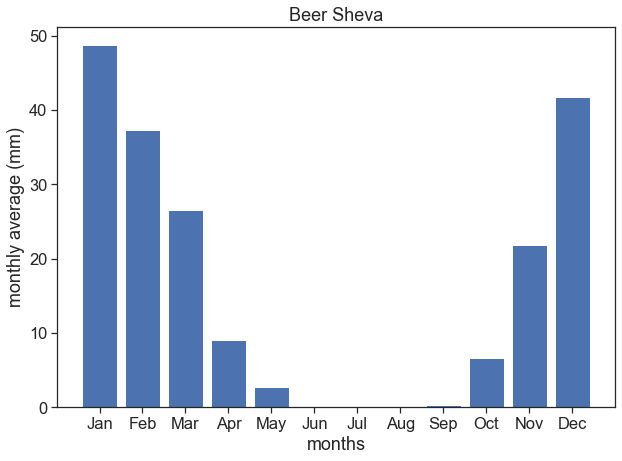

In [7]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_beersheva['month number'], df_beersheva['monthly rainfall (mm)'])
ax.set(xlabel="months",
       ylabel="monthly average (mm)",
       title="Beer Sheva",
       xticks=df_beersheva['month number'],
       xticklabels=df_beersheva['month names']);
plt.savefig("hydrology_figures/beersheva_monthly_average.png")

Let's calculate now the Walsh and Lawler Seasonality Index.  
**Write a function** that receives a dataframe like the one we have just created, and returns the seasonality index.  
http://leddris.aegean.gr/ses-parameters/293-rainfall-seasonality.html#:~:text=Rainfall%20seasonality%20index%20is%20a,in%20relation%20to%20water%20availability

$R=$ mean annual precipitation  
$m_i$ precipitation mean for month $i$  

$$ SI = \displaystyle \frac{1}{R} \sum_{n=1}^{n=12} \left| m_i - \frac{R}{12} \right| $$

| SI | Precipitation Regime |
| --- | --- |
| <0.19 | Precipitation spread throughout the year |
| 0.20-0.39	 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59	 | Rather seasonal with a short dry season |
| 0.60-0.79	 | Seasonal |
| 0.80-0.99	 | Marked seasonal with a long dry season |
| 1.00-1.19		 | Most precipitation in < 3 months |

In [8]:
#collapse-hide

def walsh_index(df):
    mi = df["monthly rainfall (mm)"]
    R = df["monthly rainfall (mm)"].sum()
    SI = np.sum(np.abs(mi - R/12)) / R
    return SI
beersheva_SI = walsh_index(df_beersheva)
print(f"Beer Sheva, SI = {beersheva_SI:.2f}")

Beer Sheva, SI = 0.97


# interannual variability

Plot monthly rainfall for your station.  

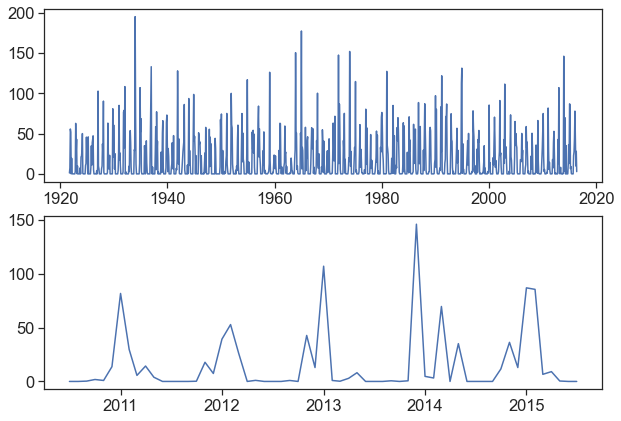

In [9]:
#collapse-hide

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
ax1.plot(df['PRCP'])
ax2.plot(df['PRCP']['2010-07-01':'2015-07-01'])

How to aggregate rainfall accoding to the hydrological year? We use the function `resample`.

read more about resampling options:  
https://pandas.pydata.org/pandas-docs/version/0.12.0/timeseries.html#offset-aliases

also, annual resampling can be anchored to the end of specific months:
https://pandas.pydata.org/pandas-docs/version/0.12.0/timeseries.html#anchored-offsets

In [10]:
#collapse-hide

# annual frequency, anchored 31 December
df_year_all = df['PRCP'].resample('A').sum().to_frame()
# annual frequency, anchored 01 January
df_year_all = df['PRCP'].resample('AS').sum().to_frame()
# annual frequency, anchored end of September
df_year_all = df['PRCP'].resample('A-SEP').sum().to_frame()
# rename 'PRCP' column to 'rain (mm)'
df_year_all.columns = ['rain (mm)']
df_year_all

,rain (mm)
DATE,
1922-09-30,136.6
1923-09-30,144.5
1924-09-30,130.4
1925-09-30,165.3
1926-09-30,188.7
...,...
2012-09-30,145.7
2013-09-30,175.3
2014-09-30,259.2


You might need to exclude the first or the last line, since their data might have less that 12 months. For example:

In [11]:
#collapse-hide

# exclude 1st row
df_year = df_year_all.iloc[1:]
# exclude last row
df_year = df_year_all.iloc[:-1]
# exclude both 1st and last rows
df_year = df_year_all.iloc[1:-1]
df_year

,rain (mm)
DATE,
1923-09-30,144.5
1924-09-30,130.4
1925-09-30,165.3
1926-09-30,188.7
1927-09-30,130.2
...,...
2011-09-30,151.6
2012-09-30,145.7
2013-09-30,175.3


Calculate the average annual rainfall. Plot annual rainfall for the whole range, together with the average. You should get something like this:

/Users/yairmau/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:2127: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  dx = [convert(x0 + ddx) - x for ddx in dx]


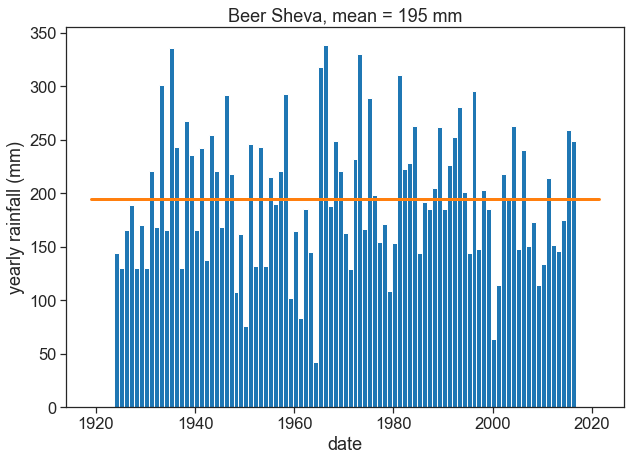

In [12]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))

# plot YEARLY precipitation
ax.bar(df_year.index, df_year['rain (mm)'],
       width=365, align='edge', color="tab:blue")

# plot mean
rain_mean = df_year['rain (mm)'].mean()
ax.plot(ax.get_xlim(), [rain_mean]*2, linewidth=3, color="tab:orange")
ax.set(xlabel="date",
       ylabel="yearly rainfall (mm)",
       title=f"Beer Sheva, mean = {rain_mean:.0f} mm");
# save figure
plt.savefig("hydrology_figures/beersheva_yearly_rainfall_1923_2016.png")

Plot a histogram of annual rainfall, with the mean and standard deviation. Calculate the coefficient of variation. Try to plot something like this:

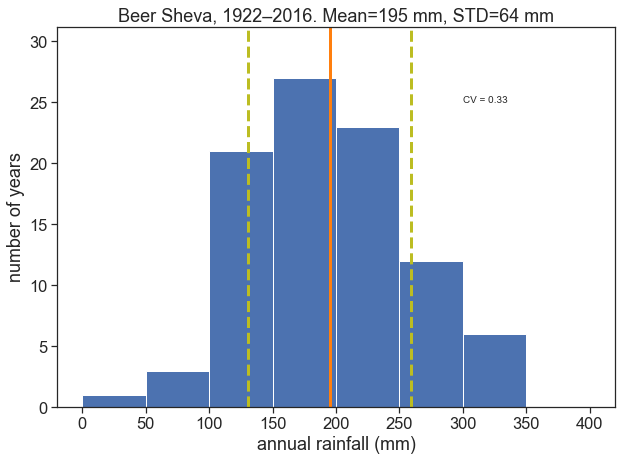

In [13]:
#collapse-hide

fig, ax = plt.subplots(figsize=(10,7))

# calculate mean and standard deviation
rain_mean = df_year['rain (mm)'].mean()
rain_std = df_year['rain (mm)'].std()

# plot histogram
b = np.arange(0, 401, 50)  # bins from 0 to 400, width = 50
ax.hist(df_year['rain (mm)'], bins=b)

# plot vertical lines with mean, std, etc
ylim = np.array(ax.get_ylim())
ylim[1] = ylim[1]*1.1
ax.plot([rain_mean]*2, ylim, linewidth=3, color="tab:orange")
ax.plot([rain_mean+rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.plot([rain_mean-rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:olive")
ax.set(ylim=ylim,
       xlabel="annual rainfall (mm)",
       ylabel="number of years",
       title=f"Beer Sheva, 1922–2016. Mean={rain_mean:.0f} mm, STD={rain_std:.0f} mm")
ax.text(300, 25, f"CV = {rain_std/rain_mean:.2f}")
plt.savefig("histogram_beersheva.png")

Calculate the mean annual rainfall for various 30-year intervals

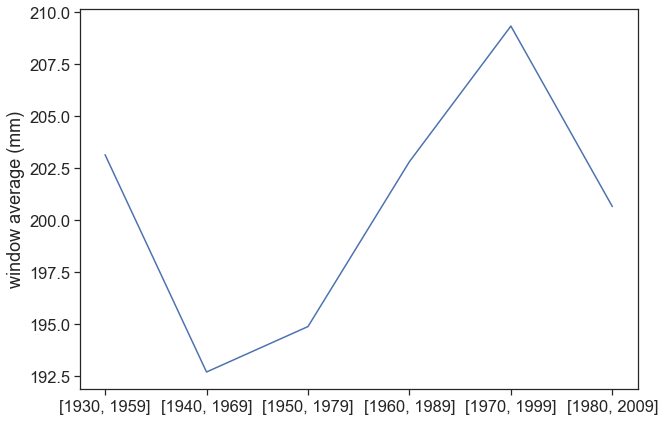

In [14]:
#collapse-hide

####### the hard way #######
# fig, ax = plt.subplots(figsize=(10,7))

# mean_30_59 = df_year.loc['1930-09-30':'1959-09-01','rain (mm)'].mean()
# mean_40_69 = df_year.loc['1940-09-30':'1969-09-01','rain (mm)'].mean()
# mean_50_79 = df_year.loc['1950-09-30':'1979-09-01','rain (mm)'].mean()
# mean_60_89 = df_year.loc['1960-09-30':'1989-09-01','rain (mm)'].mean()
# mean_70_99 = df_year.loc['1970-09-30':'1999-09-01','rain (mm)'].mean()
# mean_80_09 = df_year.loc['1980-09-30':'2009-09-01','rain (mm)'].mean()

# ax.plot([mean_30_59,
#          mean_40_69,
#          mean_50_79,
#          mean_60_89,
#          mean_70_99,
#          mean_80_09])


####### the easy way #######

fig, ax = plt.subplots(figsize=(10,7))

# use list comprehension
windows = [[x, x+29] for x in [1930,1940,1950,1960,1970,1980]]
mean = [df_year.loc[f'{w[0]:d}-09-30':f'{w[1]:d}-09-01','rain (mm)'].mean() for w in windows]
ax.plot(mean)
ax.set(xticks=np.arange(len(mean)),
       xticklabels=[str(w) for w in windows],
       ylabel="window average (mm)"
      );

## homework

1. Download both daily and monthly data for London (LONDON HEATHROW, ID: UKM00003772). You should be aware that 'PRCP' for monthly data is in millimeters, while 'PRCP' for daily data is in **tens of millimiters**.
2. Aggregate daily data into monthly intervals using resample('MS').sum(). 'MS' means that the sum of all days in the month will be stored in the first day of the month. Supposedly both datasets are equal now.
3. Calculate the average annual rainfall, using each of these datasets.
4. Why is there such a big difference?